In [1]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 0.1  #non-IID

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Client 0 train samples: 2278
Client 1 train samples: 670
Client 2 train samples: 1173
Client 3 train samples: 1591
Client train: 1823, test: 455
Client train: 536, test: 134
Client train: 939, test: 234
Client train: 1273, test: 318
Client 0:
  glioma: 926 samples
  meningioma: 53 samples
  notumor: 0 samples
  pituitary: 844 samples
------------------------------
Client 1:
  glioma: 125 samples
  meningioma: 411 samples
  notumor: 0 samples
  pituitary: 0 samples
------------------------------
Client 2:
  glioma: 0 samples
  meningioma: 609 samples
  notumor: 7 samples
  pituitary: 323 samples
------------------------------
Client 3:
  glioma: 1 samples
  meningioma: 1 samples
  notumor: 1270 samples
  pituitary: 1 samples
------------------------------
Client 0:
  Training set:
    glioma: 926 samples
    meningioma: 53 samples
    notumor: 0 samples
    pituitary: 844 samples
  Testing set:
    glioma: 238 samples
    meningioma: 12 samples
  

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(client_subsets, class_names, alpha_value):
    num_clients = len(client_subsets)
    num_classes = len(class_names)

    # Count per-class samples for each client
    dist_matrix = np.zeros((num_clients, num_classes), dtype=int)

    for client_id, subset in enumerate(client_subsets):
        labels = [subset[i][1] for i in range(len(subset))]
        for cls in range(num_classes):
            dist_matrix[client_id, cls] = labels.count(cls)

    # ----------- Plot Bar Chart -----------
    x = np.arange(num_clients)
    width = 0.2   # width of each bar

    plt.figure(figsize=(10,5))
    
    for cls in range(num_classes):
        plt.bar(x + cls*width, dist_matrix[:, cls], width, label=class_names[cls])

    plt.xticks(x + width, [f"client_{i}" for i in range(num_clients)])
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution (Dirichlet α = {alpha_value})")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()

    return dist_matrix


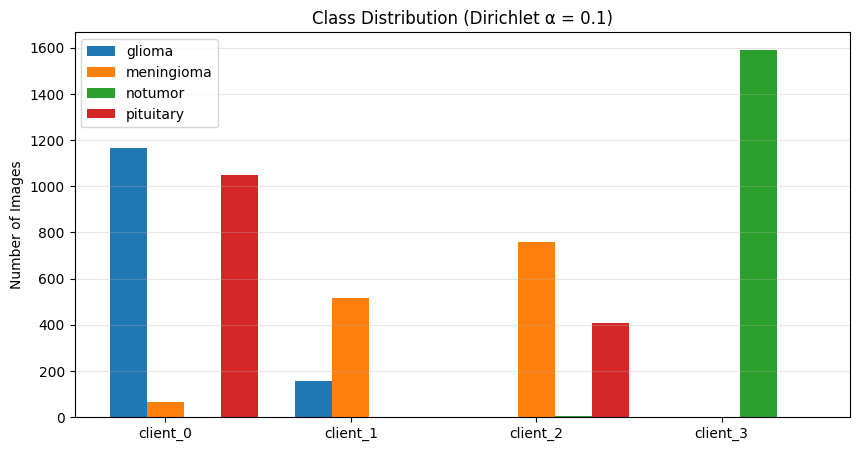

In [3]:
dist_extreme = plot_class_distribution(client_subsets, class_names, alpha_value=0.1)


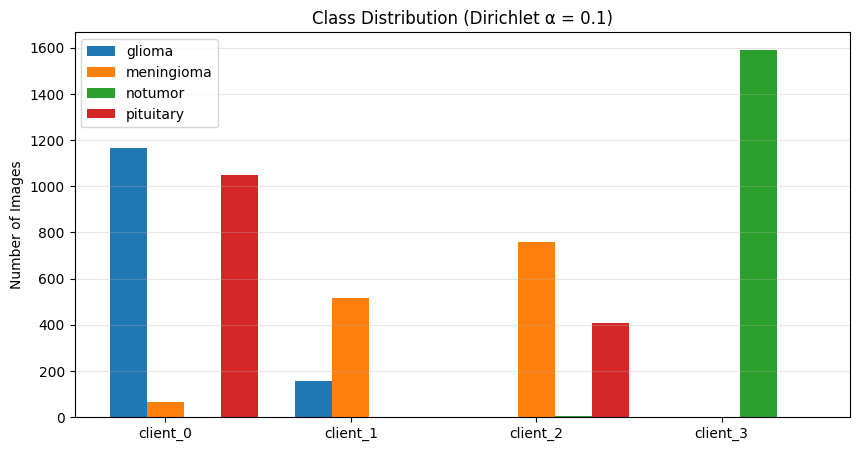

In [4]:
dist_extreme = plot_class_distribution(client_subsets, class_names, alpha_value=0.1)


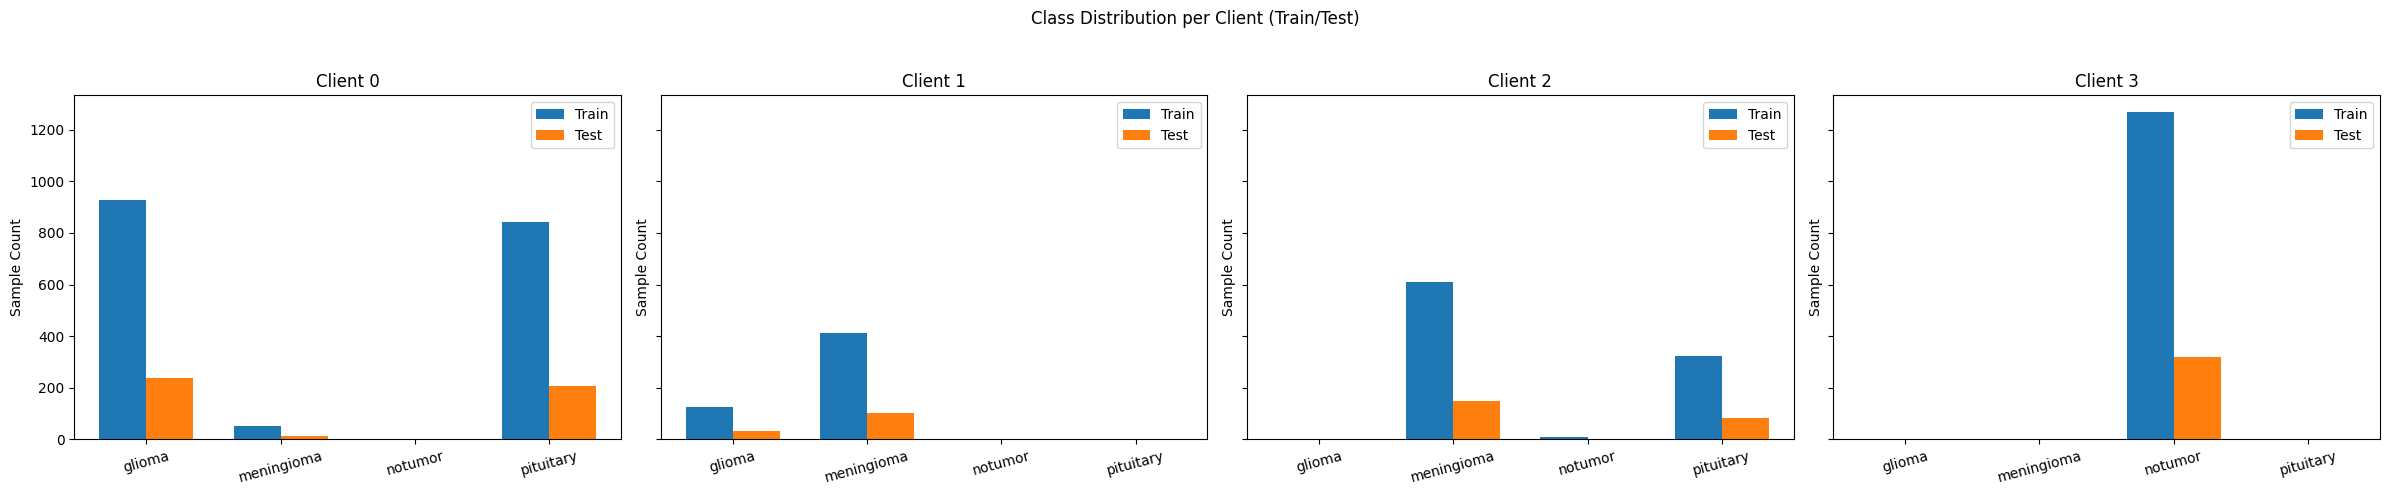

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


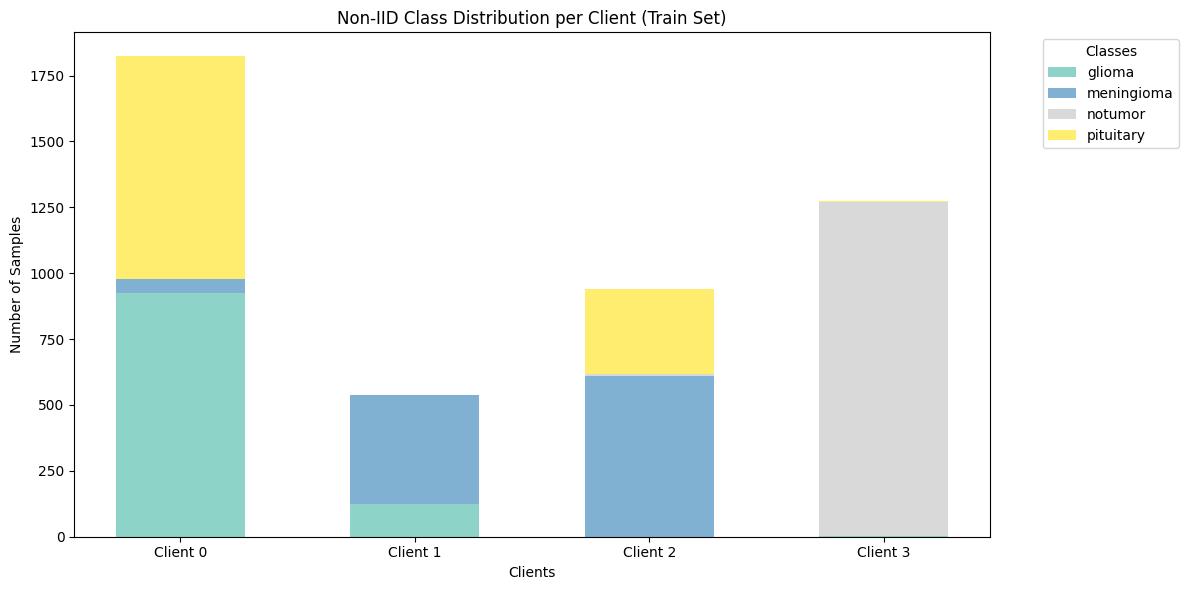

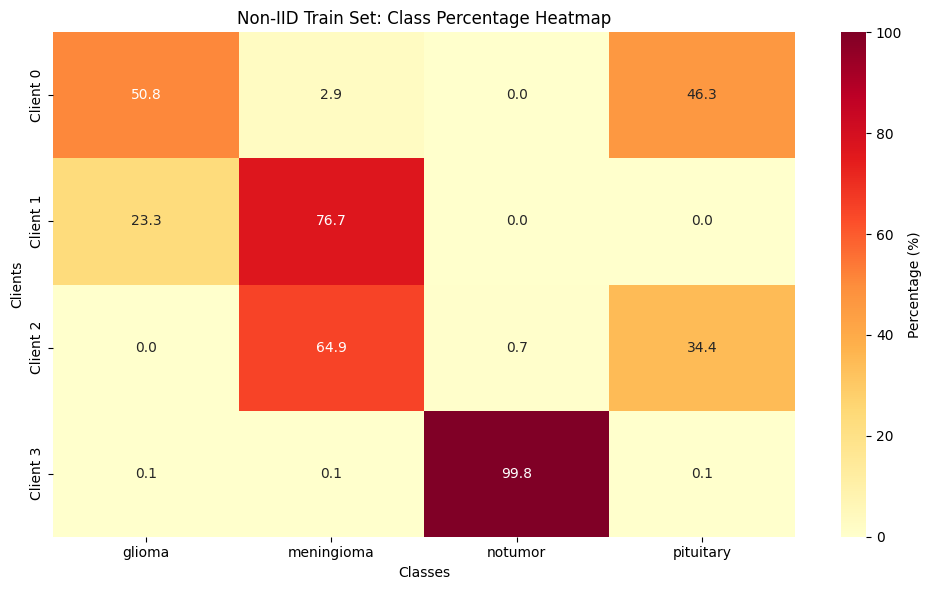

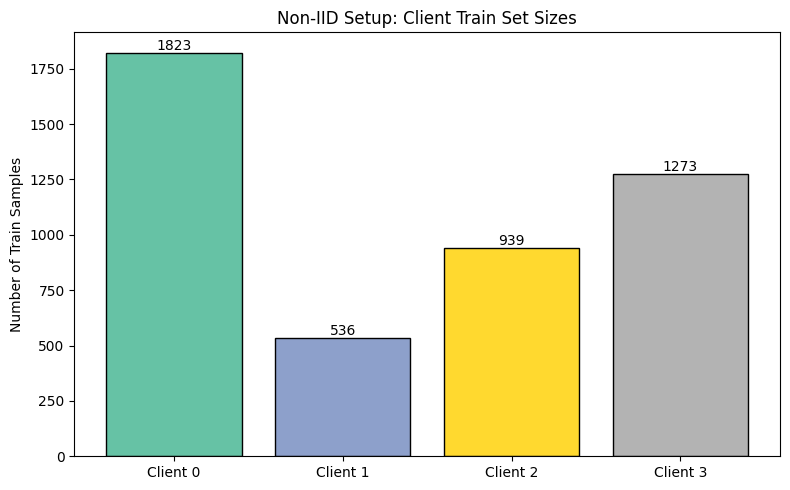

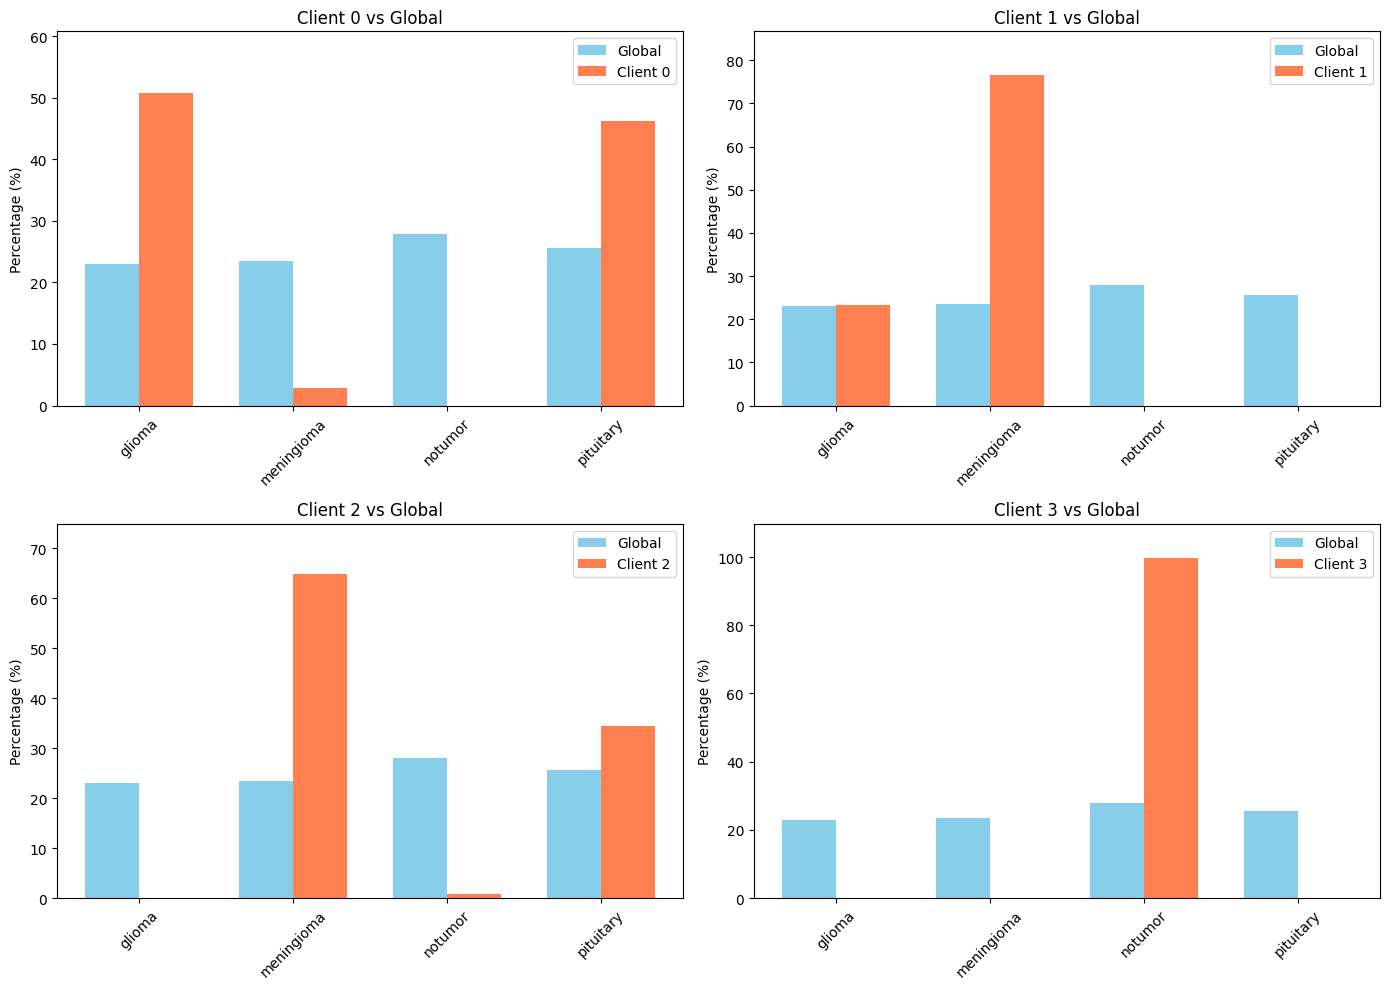


NON-IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1823 samples
  glioma: 926 (50.8%)
  meningioma: 53 (2.9%)
  notumor: 0 (0.0%)
  pituitary: 844 (46.3%)

Client 1: 536 samples
  glioma: 125 (23.3%)
  meningioma: 411 (76.7%)
  notumor: 0 (0.0%)
  pituitary: 0 (0.0%)

Client 2: 939 samples
  glioma: 0 (0.0%)
  meningioma: 609 (64.9%)
  notumor: 7 (0.7%)
  pituitary: 323 (34.4%)

Client 3: 1273 samples
  glioma: 1 (0.1%)
  meningioma: 1 (0.1%)
  notumor: 1270 (99.8%)
  pituitary: 1 (0.1%)

Global Distribution (Train Set):
  glioma: 1052 (23.0%)
  meningioma: 1074 (23.5%)
  notumor: 1277 (27.9%)
  pituitary: 1168 (25.6%)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [7]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# ----- 1. Prepare class distributions -----

# Get number of classes
num_classes = len(train_dataset.classes)

# Extract class distributions for each client
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]  # (filename, class_idx)
        counts[class_idx] += 1
    # Normalize to probabilities
    if counts.sum() > 0:
        prob_vec = counts / counts.sum()
    else:
        prob_vec = counts
    client_distributions.append(prob_vec)

# ----- 2. Compute global class distribution -----
global_counts = np.zeros(num_classes)
for sample in train_dataset.samples:
    class_idx = sample[1]
    global_counts[class_idx] += 1
global_dist = global_counts / global_counts.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# ----- 3. Compute Jensen-Shannon Divergence (JS Divergence) -----
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_divergences = []
for k, client_dist in enumerate(client_distributions):
    js_div = jensenshannon(global_dist, client_dist)
    js_divergences.append(js_div)
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(js_divergences)
print(f"\nAverage JS Divergence: {avg_js:.4f}")


Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.4298
Client 1: JS Divergence = 0.5097
Client 2: JS Divergence = 0.4672
Client 3: JS Divergence = 0.5926

Average JS Divergence: 0.4998


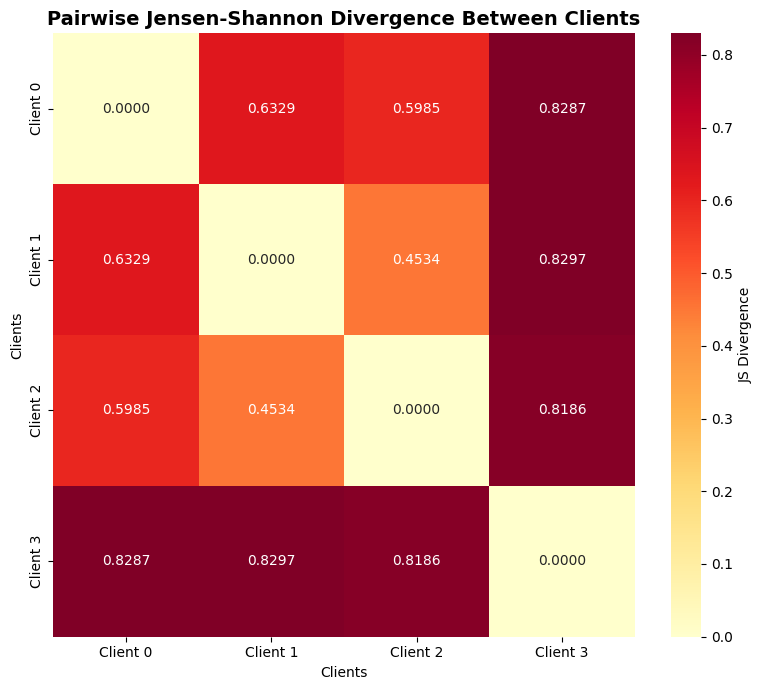

In [8]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 1. Prepare client class probability distributions -----
num_classes = len(train_dataset.classes)
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]
        counts[class_idx] += 1
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# ----- 2. Compute pairwise JS divergence matrix -----
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(NUM_CLIENTS):
        pairwise_js[i, j] = jensenshannon(client_distributions[i], client_distributions[j])

# ----- 3. Plot pairwise JS divergence heatmap -----
plt.figure(figsize=(8, 7))
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            yticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            cbar_kws={'label': 'JS Divergence'})
plt.title('Pairwise Jensen-Shannon Divergence Between Clients', fontsize=14, fontweight='bold')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()


In [9]:
import torch
print("MPS available:", torch.backends.mps.is_available())


MPS available: True


In [15]:
# ============================================================
#     FEDAVG (EXTREME NON-IID) — PRETRAINED RESNET18
# ============================================================

import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


# ============================================================
#                    DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥 Using CPU")


# ============================================================
#   CONFIG (EXTREME NON-IID FEDAVG — PRETRAINED RESNET18)
# ============================================================
SEED_EXT          = 77
NUM_ROUNDS_EXT    = 30
LOCAL_EPOCHS_EXT  = 5
LR_EXT            = 3e-4
BATCH_SIZE_EXT    = 32

# Extreme non-IID client partitions (YOU create this elsewhere)
# client_data_extreme = [(train_subset_0, test_subset_0), ..., (train_subset_N, test_subset_N)]

NUM_CLIENTS_EXT   = len(client_data)
NUM_CLASSES_EXT   = len(train_dataset.classes)


# ----------------- REPRODUCIBILITY -----------------
random.seed(SEED_EXT)
np.random.seed(SEED_EXT)
torch.manual_seed(SEED_EXT)
torch.cuda.manual_seed_all(SEED_EXT)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_ext = nn.CrossEntropyLoss()


# ============================================================
#     PRETRAINED RESNET18 WITH FREEZING STRATEGY (EXTREME)
# ============================================================
def create_pretrained_resnet18_ext(num_classes: int) -> nn.Module:
    """
    Same architecture & freezing as moderate/IID experiments,
    but kept separate for the EXTREME non-IID setting.
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze low / early layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    return model


# ============================================================
#                TRAINING + EVALUATION (EXTREME)
# ============================================================
def train_one_epoch_ext(model, loader, device, optimizer):
    model.train()
    tot_loss = 0.0
    tot_corr = 0
    tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = crit_ce_ext(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += bs

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


@torch.no_grad()
def evaluate_ext(model, loader, device):
    model.eval()
    tot_loss = 0.0
    tot_corr = 0
    tot = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = crit_ce_ext(logits, y)

        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_corr += (logits.argmax(1) == y).sum().item()
        tot += bs

    return {"loss": tot_loss / tot, "acc": tot_corr / tot}


# ============================================================
#        BUILD CLIENT TRAIN + LOCAL TEST LOADERS (EXTREME)
# ============================================================
client_train_loaders_ext = []
client_test_loaders_ext  = []

for train_subset, test_subset in client_data:
    client_train_loaders_ext.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_EXT, shuffle=True)
    )
    client_test_loaders_ext.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_EXT, shuffle=False)
    )


# ============================================================
#        GLOBAL HOLDOUT LOADER (TRUE GLOBAL TEST SET)
# ============================================================
# Uses the Testing/ directory dataset as global holdout
holdout_loader_ext = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EXT,
    shuffle=False
)


# ============================================================
#        GLOBAL MODEL INITIALIZATION (EXTREME)
# ============================================================
global_model_ext = create_pretrained_resnet18_ext(NUM_CLASSES_EXT).to(DEVICE)

best_acc_ext  = -1.0
best_state_ext = None

metrics_history_fedavg_extreme_pretrained = {
    "round":   [],
    "holdout": [],                        # list of {"loss": ..., "acc": ...}
    "clients": {k: [] for k in range(NUM_CLIENTS_EXT)}
}


# ============================================================
#                     FEDAVG TRAINING LOOP (EXTREME)
# ============================================================
for rnd in range(NUM_ROUNDS_EXT):

    print(f"\n🔁 [EXTREME] FedAvg Pretrained Round {rnd+1}/{NUM_ROUNDS_EXT}")

    local_states = []

    # ----- CLIENT TRAINING -----
    for k in range(NUM_CLIENTS_EXT):

        # Local copy of global model
        local_model = copy.deepcopy(global_model_ext).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_EXT
        )

        # Local epochs
        for ep in range(LOCAL_EPOCHS_EXT):
            train_one_epoch_ext(local_model, client_train_loaders_ext[k], DEVICE, optimizer)

        # Save model params (to CPU for aggregation)
        local_states.append({
            name: param.cpu() for name, param in local_model.state_dict().items()
        })

        # Per-client evaluation on its local test split
        client_metric = evaluate_ext(local_model, client_test_loaders_ext[k], DEVICE)
        metrics_history_fedavg_extreme_pretrained["clients"][k].append(client_metric)

        print(f"  Client {k} | Local Test Acc: {client_metric['acc']:.4f}")


    # ----- FEDAVG AGGREGATION -----
    new_state = {}
    for key in global_model_ext.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            # e.g. num_batches_tracked (ints)
            new_state[key] = stacked[0]

    global_model_ext.load_state_dict(new_state)

    # ----- GLOBAL HOLDOUT EVAL (ON GLOBAL TEST SET) -----
    holdout_metric = evaluate_ext(global_model_ext, holdout_loader_ext, DEVICE)

    metrics_history_fedavg_extreme_pretrained["round"].append(rnd + 1)
    metrics_history_fedavg_extreme_pretrained["holdout"].append(holdout_metric)

    print(
        f"🌍 [EXTREME] Global Holdout | "
        f"Acc: {holdout_metric['acc']:.4f}, "
        f"Loss: {holdout_metric['loss']:.4f}"
    )

    # ----- SAVE BEST GLOBAL MODEL -----
    if holdout_metric["acc"] > best_acc_ext:
        best_acc_ext  = holdout_metric["acc"]
        best_state_ext = copy.deepcopy(global_model_ext.state_dict())
        print(f"💾 New BEST [EXTREME] Model Saved! Acc = {best_acc_ext:.4f}")


# ============================================================
#                   SAVE OUTPUTS (EXTREME NON-IID)
# ============================================================
torch.save(best_state_ext, "best_fedavg_extreme_pretrained.pth")
np.save(
    "metrics_history_fedavg_extreme_pretrained.npy",
    metrics_history_fedavg_extreme_pretrained
)

print("\n✅ Saved:")
print("   • best_fedavg_extreme_pretrained.pth")
print("   • metrics_history_fedavg_extreme_pretrained.npy")


🚀 Using Apple Silicon GPU (MPS)

🔁 [EXTREME] FedAvg Pretrained Round 1/30
  Client 0 | Local Test Acc: 0.9736
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9487
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] Global Holdout | Acc: 0.5515, Loss: 1.1378
💾 New BEST [EXTREME] Model Saved! Acc = 0.5515

🔁 [EXTREME] FedAvg Pretrained Round 2/30
  Client 0 | Local Test Acc: 0.9780
  Client 1 | Local Test Acc: 0.9851
  Client 2 | Local Test Acc: 0.9573
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] Global Holdout | Acc: 0.3776, Loss: 1.2792

🔁 [EXTREME] FedAvg Pretrained Round 3/30
  Client 0 | Local Test Acc: 0.9714
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9786
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] Global Holdout | Acc: 0.5850, Loss: 1.0895
💾 New BEST [EXTREME] Model Saved! Acc = 0.5850

🔁 [EXTREME] FedAvg Pretrained Round 4/30
  Client 0 | Local Test Acc: 0.9868
  Client 1 | Local Test Acc: 0.9701
  Client 2 | Local Test Acc: 0.9231
 

Using: mps


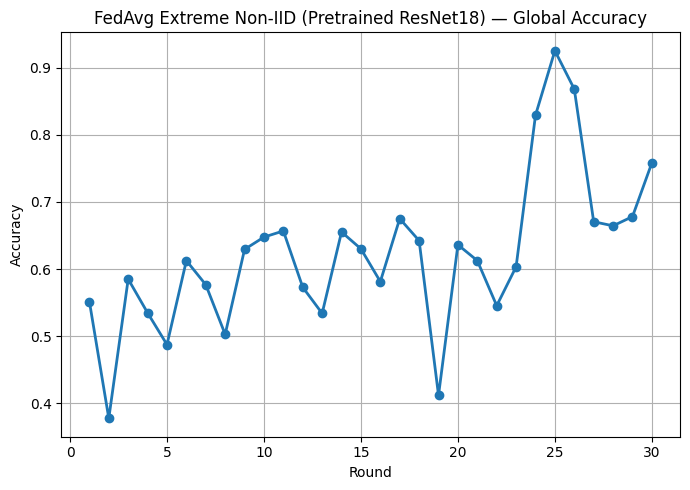

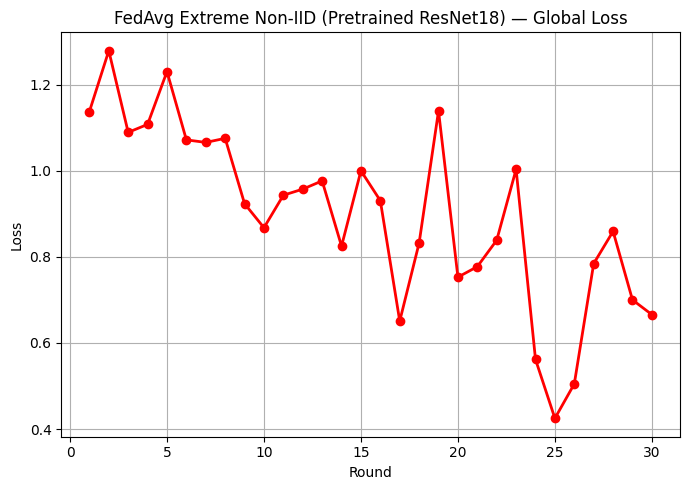

Saved: fedavg_extreme_rounds.npy, fedavg_extreme_acc.npy, fedavg_extreme_loss.npy

Loaded BEST FedAvg Extreme Non-IID model!

========== FedAvg Extreme Non-IID — GLOBAL METRICS ==========
Accuracy :  0.9252
Loss     :  0.4248
Precision:  0.9251
Recall   :  0.9315
F1-Score :  0.9262



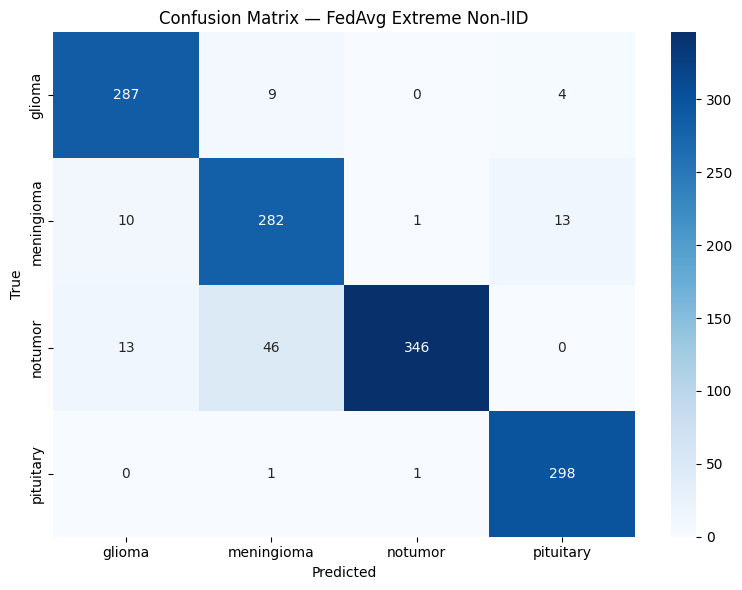

Saved: fedavg_extreme_confusion_matrix.npy


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torchvision import models
import torch.nn as nn


# ============================================================
#  DEVICE
# ============================================================
DEVICE = torch.device("mps" if torch.backends.mps.is_available()
          else "cuda" if torch.cuda.is_available()
          else "cpu")
print("Using:", DEVICE)


# ============================================================
#  LOAD METRICS FROM FEDAVG EXTREME EXPERIMENT
# ============================================================
history_ext = np.load("metrics_history_fedavg_extreme_pretrained.npy",
                      allow_pickle=True).item()

rounds_ext  = history_ext["round"]
holdout_ext = history_ext["holdout"]

accs_ext  = [m["acc"] for m in holdout_ext]
losses_ext = [m["loss"] for m in holdout_ext]


# ============================================================
#  PLOT GLOBAL ACCURACY OVER ROUNDS
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds_ext, accs_ext, marker='o', linewidth=2)
plt.title("FedAvg Extreme Non-IID (Pretrained ResNet18) — Global Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
#  PLOT GLOBAL LOSS OVER ROUNDS
# ============================================================
plt.figure(figsize=(7, 5))
plt.plot(rounds_ext, losses_ext, marker='o', color="red", linewidth=2)
plt.title("FedAvg Extreme Non-IID (Pretrained ResNet18) — Global Loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
#  SAVE METRIC ARRAYS FOR LATER COMPARISON
# ============================================================
np.save("fedavg_extreme_rounds.npy", np.array(rounds_ext))
np.save("fedavg_extreme_acc.npy", np.array(accs_ext))
np.save("fedavg_extreme_loss.npy", np.array(losses_ext))

print("Saved: fedavg_extreme_rounds.npy, fedavg_extreme_acc.npy, fedavg_extreme_loss.npy")


# ============================================================
#  REBUILD RESNET18 ARCHITECTURE (MUST MATCH TRAINING)
# ============================================================
def create_resnet18_ext_eval(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Same freezing as training
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters():   p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
#  LOAD BEST EXTREME FEDAVG MODEL
# ============================================================
best_ext_model = create_resnet18_ext_eval(NUM_CLASSES_EXT).to(DEVICE)
best_ext_model.load_state_dict(torch.load("best_fedavg_extreme_pretrained.pth",
                                          map_location=DEVICE))
best_ext_model.eval()

print("\nLoaded BEST FedAvg Extreme Non-IID model!\n")


# ============================================================
#  EVALUATE ON GLOBAL TEST SET
# ============================================================
all_preds = []
all_labels = []
criterion = nn.CrossEntropyLoss()
total_loss = 0
total_samples = 0

with torch.no_grad():
    for x, y in holdout_loader_ext:
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = best_ext_model(x)
        loss = criterion(logits, y)

        preds = logits.argmax(dim=1)

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

final_acc   = (all_preds == all_labels).mean()
final_loss  = total_loss / total_samples
precision   = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall      = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1          = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print("========== FedAvg Extreme Non-IID — GLOBAL METRICS ==========")
print(f"Accuracy :  {final_acc:.4f}")
print(f"Loss     :  {final_loss:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"F1-Score :  {f1:.4f}")
print("==============================================================\n")


# ============================================================
#  CONFUSION MATRIX (GLOBAL TEST SET)
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — FedAvg Extreme Non-IID")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# ============================================================
#  SAVE CONFUSION MATRIX
# ============================================================
np.save("fedavg_extreme_confusion_matrix.npy", cm)
print("Saved: fedavg_extreme_confusion_matrix.npy")


In [17]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# ============================================================
#                    DEVICE SELECTION
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#        CONFIG — FedProx + Pretrained ResNet18 (EXTREME)
# ============================================================
SEED_EXT_FP        = 77
NUM_ROUNDS_EXT_FP  = 30        # federated rounds
LOCAL_EPOCHS_EXT_FP = 5        # local epochs per round
LR_EXT_FP          = 3e-4      # learning rate
FEDPROX_MU_EXT     = 1e-3      # FedProx μ for extreme non-IID
BATCH_SIZE_EXT_FP  = 32

# Extreme non-IID partitions already built as in your Dirichlet code:
# client_data = [(client0_train, client0_test), ..., (clientN_train, clientN_test)]
NUM_CLIENTS_EXT_FP = len(client_data)
NUM_CLASSES_EXT_FP = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED_EXT_FP)
np.random.seed(SEED_EXT_FP)
torch.manual_seed(SEED_EXT_FP)
torch.cuda.manual_seed_all(SEED_EXT_FP)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_ext_fp = nn.CrossEntropyLoss()

# ============================================================
#      PRETRAINED RESNET18 (SAME FREEZING AS OTHER EXPERIMENTS)
# ============================================================
def create_pretrained_resnet18_ext_fedprox(num_classes: int) -> nn.Module:
    """
    ResNet18 with ImageNet weights for Extreme Non-IID FedProx.
    Freeze: conv1, bn1, layer1, layer2
    Train : layer3, layer4, fc
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Fine-tune deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#                   CLIENT LOADERS (EXTREME)
# ============================================================
client_train_loaders_ext_fp = []
client_test_loaders_ext_fp  = []

for train_subset, test_subset in client_data:
    client_train_loaders_ext_fp.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=True, num_workers=0)
    )
    client_test_loaders_ext_fp.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=False, num_workers=0)
    )

# -------- GLOBAL HOLDOUT LOADER (TRUE TEST SET) --------
holdout_loader_ext_fp = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EXT_FP,
    shuffle=False,
    num_workers=0
)
print(f"Extreme FedProx — Global holdout size: {len(test_dataset)}")

# ============================================================
#               GENERIC EVAL FUNCTION (REUSED)
# ============================================================
@torch.no_grad()
def evaluate_ext_fp(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce_ext_fp(logits, y)

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#               FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch_ext_fp(model, loader, device, optimizer, global_params, mu):
    """
    One local epoch of FedProx for extreme non-IID clients.
    global_params: dict[name -> tensor] from the global model.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce_ext_fp(logits, y)

        # Proximal penalty (only for trainable parameters)
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:
                prox_term = prox_term + ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#             INITIALIZE GLOBAL FedProx MODEL (EXTREME)
# ============================================================
global_model_ext_fp = create_pretrained_resnet18_ext_fedprox(NUM_CLASSES_EXT_FP).to(DEVICE)

best_global_acc_ext_fp   = -1.0
best_global_state_ext_fp = None

metrics_history_fedprox_extreme_pretrained = {
    "round":   [],
    "holdout": [],                          # list of {"loss":..., "acc":...}
    "clients": {k: [] for k in range(NUM_CLIENTS_EXT_FP)}  # per-client metrics
}

# ============================================================
#                     FEDPROX MAIN LOOP (EXTREME)
# ============================================================
for rnd in range(NUM_ROUNDS_EXT_FP):
    print(f"\n🔁 [EXTREME] FedProx Pretrained Round {rnd+1}/{NUM_ROUNDS_EXT_FP}")
    local_states = []

    # Cache global parameters for proximal term
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_ext_fp.named_parameters()
    }

    # ---------- LOCAL TRAINING ----------
    for k in range(NUM_CLIENTS_EXT_FP):
        local_model = copy.deepcopy(global_model_ext_fp).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_EXT_FP
        )

        for _ in range(LOCAL_EPOCHS_EXT_FP):
            train_metrics_k = train_fedprox_epoch_ext_fp(
                local_model,
                client_train_loaders_ext_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_EXT
            )

        # Store local state dict (on CPU)
        local_states.append({
            key: val.cpu() for key, val in local_model.state_dict().items()
        })

        # Evaluate on each client's local TEST split
        client_metric = evaluate_ext_fp(local_model, client_test_loaders_ext_fp[k], DEVICE)
        metrics_history_fedprox_extreme_pretrained["clients"][k].append(client_metric)
        print(f"  Client {k} | Local Test Acc: {client_metric['acc']:.4f}")

    # ---------- FEDERATED AVERAGING ----------
    new_state = {}
    for key in global_model_ext_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_ext_fp.load_state_dict(new_state)

    # ---------- GLOBAL EVALUATION ON TRUE TEST SET ----------
    holdout_metric = evaluate_ext_fp(global_model_ext_fp, holdout_loader_ext_fp, DEVICE)
    metrics_history_fedprox_extreme_pretrained["round"].append(rnd + 1)
    metrics_history_fedprox_extreme_pretrained["holdout"].append(holdout_metric)

    print(f"🌍 [EXTREME] FedProx Global | Loss: {holdout_metric['loss']:.4f} | "
          f"Acc: {holdout_metric['acc']:.4f}")

    # ---------- SAVE BEST GLOBAL MODEL ----------
    if holdout_metric["acc"] > best_global_acc_ext_fp:
        best_global_acc_ext_fp   = holdout_metric["acc"]
        best_global_state_ext_fp = copy.deepcopy(global_model_ext_fp.state_dict())
        print(f"💾 New BEST [EXTREME] FedProx Model Saved! Acc = {best_global_acc_ext_fp:.4f}")

# ============================================================
#                 SAVE BEST MODEL + METRICS (EXTREME)
# ============================================================
if best_global_state_ext_fp is not None:
    torch.save(best_global_state_ext_fp, "best_fedprox_extreme_pretrained.pth")
    print(f"\n✅ Best Extreme FedProx-pretrained model saved to "
          f"best_fedprox_extreme_pretrained.pth (Acc = {best_global_acc_ext_fp:.4f})")
else:
    print("\n⚠️ No improvement — no Extreme FedProx-pretrained model saved.")

np.save(
    "metrics_history_fedprox_extreme_pretrained.npy",
    metrics_history_fedprox_extreme_pretrained,
    allow_pickle=True
)
print("📊 Metrics history saved to metrics_history_fedprox_extreme_pretrained.npy")


🚀 Using Apple Silicon GPU (MPS)
Extreme FedProx — Global holdout size: 1311

🔁 [EXTREME] FedProx Pretrained Round 1/30
  Client 0 | Local Test Acc: 0.9824
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9530
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.0699 | Acc: 0.5645
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.5645

🔁 [EXTREME] FedProx Pretrained Round 2/30
  Client 0 | Local Test Acc: 0.9802
  Client 1 | Local Test Acc: 0.9776
  Client 2 | Local Test Acc: 0.9658
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.2526 | Acc: 0.3883

🔁 [EXTREME] FedProx Pretrained Round 3/30
  Client 0 | Local Test Acc: 0.9758
  Client 1 | Local Test Acc: 0.9851
  Client 2 | Local Test Acc: 0.9829
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.0533 | Acc: 0.5919
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.5919

🔁 [EXTREME] FedProx Pretrained Round 4/30
  Client 0 | Local Test Acc: 0.9604
  Clie

Loaded Extreme Non-IID FedProx history.
Loaded best FedProx Extreme model ✔

========== FEDPROX EXTREME NON-IID — FINAL METRICS ==========
acc       : 0.8162
loss      : 0.4621
precision : 0.8587
recall    : 0.8446
f1        : 0.8187



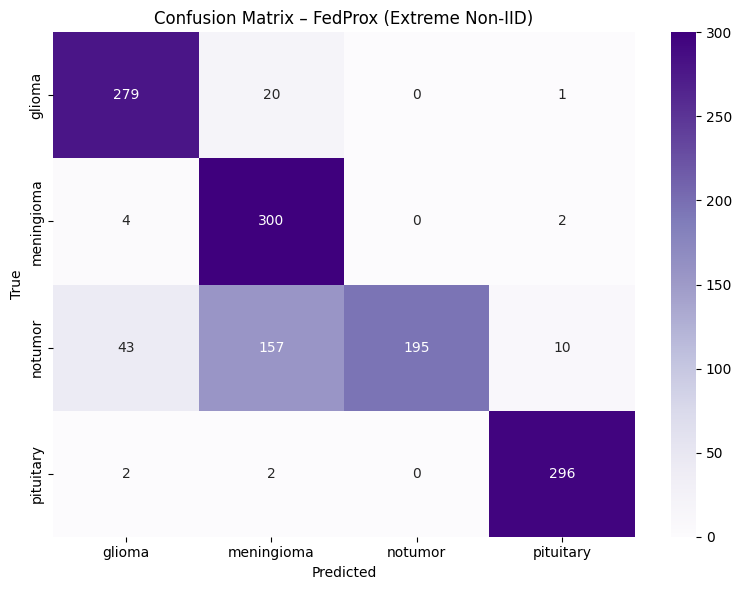

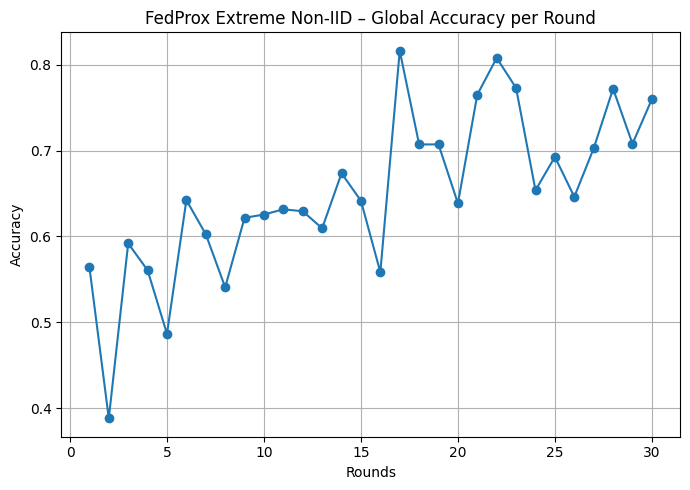

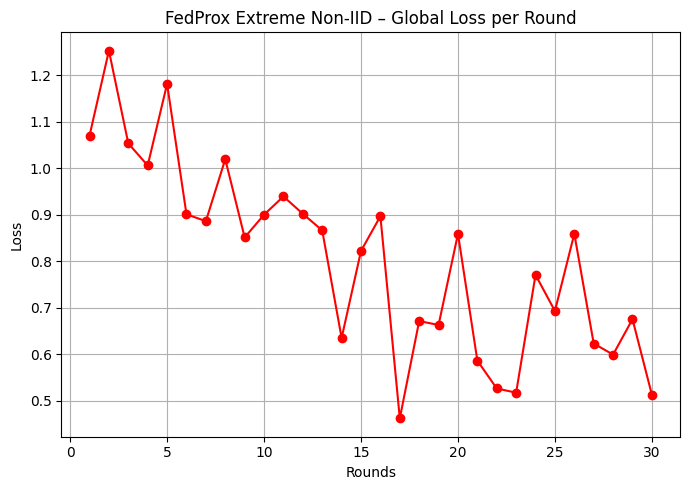

Saved: fedprox_extreme_rounds.npy, fedprox_extreme_acc.npy, fedprox_extreme_loss.npy


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torchvision import models
import torch.nn as nn

# ============================================================
# DEVICE
# ============================================================
DEVICE = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

# ============================================================
# MODEL BUILDER (same as training)
# ============================================================
def create_resnet18_extreme_eval(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
# LOAD METRICS HISTORY
# ============================================================
history_ext_fp = np.load("metrics_history_fedprox_extreme_pretrained.npy",
                         allow_pickle=True).item()

rounds_ext_fp   = history_ext_fp["round"]
holdout_metrics = history_ext_fp["holdout"]

accs_ext_fp  = [m["acc"] for m in holdout_metrics]
losses_ext_fp = [m["loss"] for m in holdout_metrics]

print("Loaded Extreme Non-IID FedProx history.")

# ============================================================
# LOAD TRAINED MODEL
# ============================================================
model_ext_fp = create_resnet18_extreme_eval(len(train_dataset.classes)).to(DEVICE)
model_ext_fp.load_state_dict(torch.load("best_fedprox_extreme_pretrained.pth",
                                        map_location=DEVICE))
model_ext_fp.eval()

print("Loaded best FedProx Extreme model ✔")

# ============================================================
# EVALUATION FUNCTION
# ============================================================
criterion = nn.CrossEntropyLoss()

def evaluate_global(model, loader):
    model.eval()
    total_loss = 0
    total = 0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds = logits.argmax(1)
            preds_all.append(preds.cpu())
            labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "acc": (preds_all == labels_all).mean(),
        "loss": total_loss / total,
        "precision": precision_score(labels_all, preds_all, average="macro", zero_division=0),
        "recall": recall_score(labels_all, preds_all, average="macro", zero_division=0),
        "f1": f1_score(labels_all, preds_all, average="macro", zero_division=0),
        "preds": preds_all,
        "labels": labels_all
    }

# ============================================================
# RUN FINAL EVALUATION ON GLOBAL TEST SET
# ============================================================
results_ext_fp = evaluate_global(model_ext_fp, holdout_loader_ext_fp)

print("\n========== FEDPROX EXTREME NON-IID — FINAL METRICS ==========")
for k, v in results_ext_fp.items():
    if k not in ("preds", "labels"):
        print(f"{k:10}: {v:.4f}")
print("==============================================================\n")

# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(results_ext_fp["labels"], results_ext_fp["preds"])
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – FedProx (Extreme Non-IID)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ============================================================
# ACCURACY CURVE
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds_ext_fp, accs_ext_fp, marker="o")
plt.title("FedProx Extreme Non-IID – Global Accuracy per Round")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# LOSS CURVE
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(rounds_ext_fp, losses_ext_fp, marker="o", color="red")
plt.title("FedProx Extreme Non-IID – Global Loss per Round")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# SAVE ARRAYS (optional)
# ============================================================
np.save("fedprox_extreme_rounds.npy",  np.array(rounds_ext_fp))
np.save("fedprox_extreme_acc.npy",     np.array(accs_ext_fp))
np.save("fedprox_extreme_loss.npy",    np.array(losses_ext_fp))

print("Saved: fedprox_extreme_rounds.npy, fedprox_extreme_acc.npy, fedprox_extreme_loss.npy")


In [39]:
import torch
import random

# pick 12 random samples from the holdout loader
samples = []
labels = []

for batch_x, batch_y in holdout_loader:
    for i in range(len(batch_x)):
        samples.append(batch_x[i])
        labels.append(batch_y[i])
        if len(samples) >= 12:
            break
    if len(samples) >= 12:
        break

samples = torch.stack(samples).to(DEVICE)
labels = torch.tensor(labels).to(DEVICE)


Using: mps
Loaded FedAvg Extreme + FedProx Extreme histories ✔
Loaded both extreme models ✔

====== FedAvg Extreme Results ======
acc: 0.9252
loss: 0.4248
precision: 0.9251
recall: 0.9315
f1: 0.9262

====== FedProx Extreme Results ======
acc: 0.8162
loss: 0.4621
precision: 0.8587
recall: 0.8446
f1: 0.8187


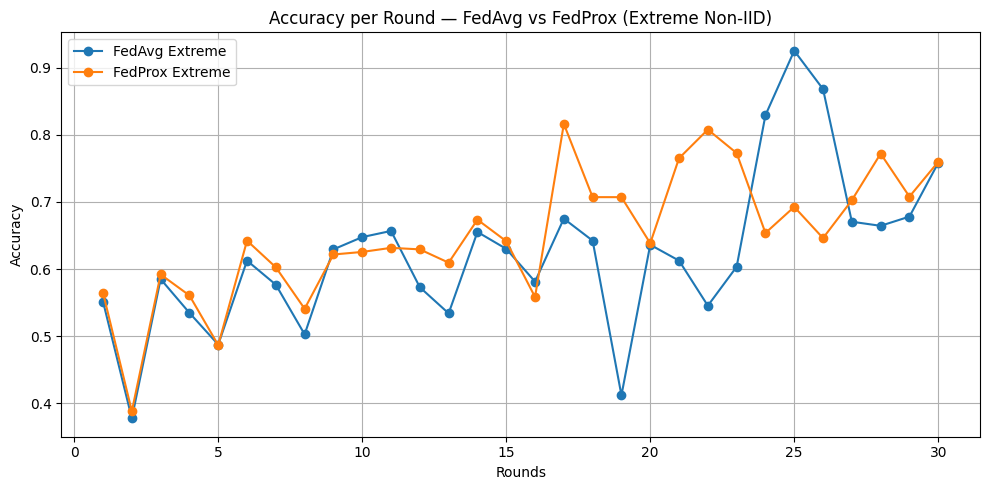

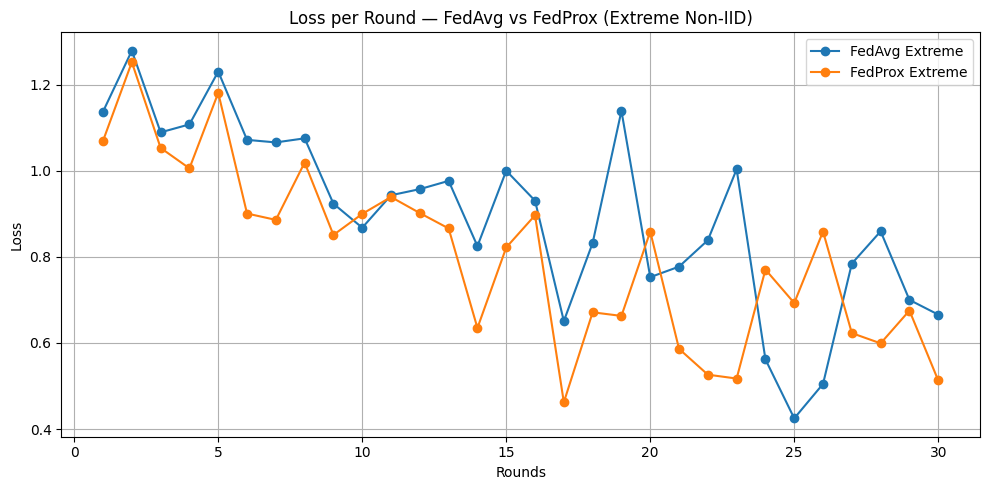

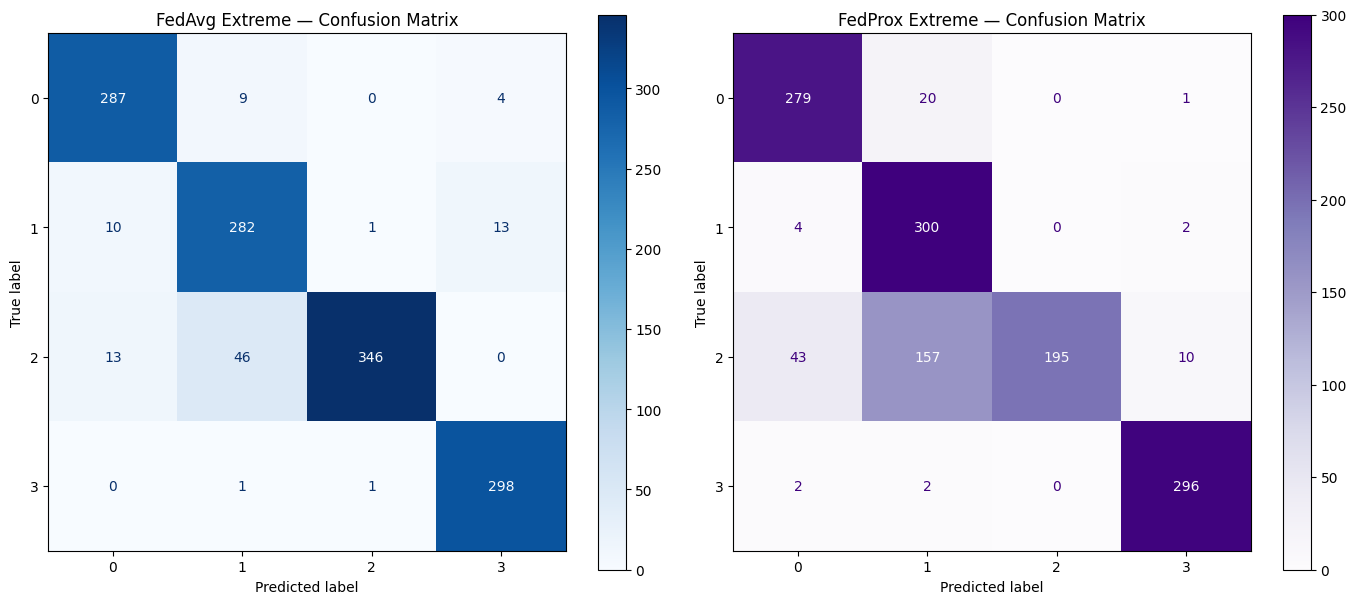

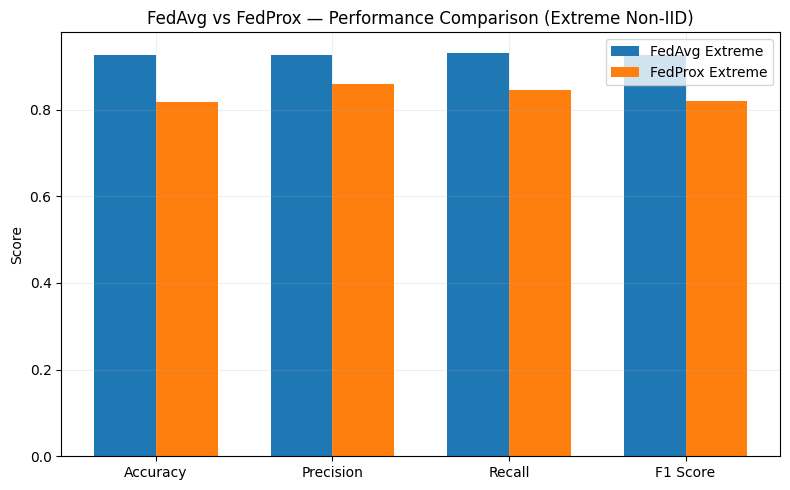

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
from torchvision import models

# ============================================================
# DEVICE
# ============================================================
DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Using:", DEVICE)


# ============================================================
# MODEL BUILDER (must match training architecture)
# ============================================================
def create_resnet18_extreme_eval(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
# LOAD METRICS HISTORY (FedAvg Extreme + FedProx Extreme)
# ============================================================
fa_hist = np.load("metrics_history_fedavg_extreme_pretrained.npy",
                  allow_pickle=True).item()

fp_hist = np.load("metrics_history_fedprox_extreme_pretrained.npy",
                  allow_pickle=True).item()

rounds_fa = fa_hist["round"]
rounds_fp = fp_hist["round"]

acc_fa = [m["acc"] for m in fa_hist["holdout"]]
acc_fp = [m["acc"] for m in fp_hist["holdout"]]

loss_fa = [m["loss"] for m in fa_hist["holdout"]]
loss_fp = [m["loss"] for m in fp_hist["holdout"]]

print("Loaded FedAvg Extreme + FedProx Extreme histories ✔")


# ============================================================
# LOAD TRAINED MODELS
# ============================================================
num_classes = len(train_dataset.classes)

model_fa = create_resnet18_extreme_eval(num_classes).to(DEVICE)
model_fa.load_state_dict(torch.load("best_fedavg_extreme_pretrained.pth",
                                    map_location=DEVICE))
model_fa.eval()

model_fp = create_resnet18_extreme_eval(num_classes).to(DEVICE)
model_fp.load_state_dict(torch.load("best_fedprox_extreme_pretrained.pth",
                                    map_location=DEVICE))
model_fp.eval()

print("Loaded both extreme models ✔")


# ============================================================
# GLOBAL EVALUATION FUNCTION
# ============================================================
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader):
    model.eval()
    preds_all = []
    labels_all = []
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            preds = logits.argmax(1)
            preds_all.append(preds.cpu())
            labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "acc": (preds_all == labels_all).mean(),
        "loss": total_loss / total_samples,
        "precision": precision_score(labels_all, preds_all, average="macro", zero_division=0),
        "recall": recall_score(labels_all, preds_all, average="macro", zero_division=0),
        "f1": f1_score(labels_all, preds_all, average="macro", zero_division=0),
        "preds": preds_all,
        "labels": labels_all,
    }


# ============================================================
# FINAL EVALUATION ON GLOBAL TEST SET
# ============================================================
fa_final = evaluate(model_fa, holdout_loader_ext_fp)
fp_final = evaluate(model_fp, holdout_loader_ext_fp)

print("\n====== FedAvg Extreme Results ======")
for k, v in fa_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")

print("\n====== FedProx Extreme Results ======")
for k, v in fp_final.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")


# ============================================================
# 📈 Accuracy Curve
# ============================================================
plt.figure(figsize=(10, 5))
plt.plot(rounds_fa, acc_fa, marker='o', label="FedAvg Extreme")
plt.plot(rounds_fp, acc_fp, marker='o', label="FedProx Extreme")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Accuracy per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# ============================================================
# 📉 Loss Curve
# ============================================================
plt.figure(figsize=(10, 5))
plt.plot(rounds_fa, loss_fa, marker='o', label="FedAvg Extreme")
plt.plot(rounds_fp, loss_fp, marker='o', label="FedProx Extreme")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Loss per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# ============================================================
# 🤝 CONFUSION MATRICES (Side-by-Side)
# ============================================================
cm_fa = confusion_matrix(fa_final["labels"], fa_final["preds"])
cm_fp = confusion_matrix(fp_final["labels"], fp_final["preds"])

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay(cm_fa).plot(ax=ax[0], cmap="Blues")
ConfusionMatrixDisplay(cm_fp).plot(ax=ax[1], cmap="Purples")

ax[0].set_title("FedAvg Extreme — Confusion Matrix")
ax[1].set_title("FedProx Extreme — Confusion Matrix")

plt.tight_layout()
plt.show()


# ============================================================
# 📊 COMPARISON BAR CHART (ACC, PRECISION, RECALL, F1)
# ============================================================
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
fa_vals = [fa_final["acc"], fa_final["precision"], fa_final["recall"], fa_final["f1"]]
fp_vals = [fp_final["acc"], fp_final["precision"], fp_final["recall"], fp_final["f1"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - w/2, fa_vals, w, label="FedAvg Extreme")
plt.bar(x + w/2, fp_vals, w, label="FedProx Extreme")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("FedAvg vs FedProx — Performance Comparison (Extreme Non-IID)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [20]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# ============================================================
#                    DEVICE SELECTION
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#        CONFIG — FedProx + Pretrained ResNet18 (EXTREME)
# ============================================================
SEED_EXT_FP        = 77
NUM_ROUNDS_EXT_FP  = 30        # federated rounds
LOCAL_EPOCHS_EXT_FP = 5        # local epochs per round
LR_EXT_FP          = 3e-4      # learning rate
FEDPROX_MU_EXT     = 1e-5      # FedProx μ for extreme non-IID
BATCH_SIZE_EXT_FP  = 32

# Extreme non-IID partitions already built as in your Dirichlet code:
# client_data = [(client0_train, client0_test), ..., (clientN_train, clientN_test)]
NUM_CLIENTS_EXT_FP = len(client_data)
NUM_CLASSES_EXT_FP = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED_EXT_FP)
np.random.seed(SEED_EXT_FP)
torch.manual_seed(SEED_EXT_FP)
torch.cuda.manual_seed_all(SEED_EXT_FP)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_ext_fp = nn.CrossEntropyLoss()

# ============================================================
#      PRETRAINED RESNET18 (SAME FREEZING AS OTHER EXPERIMENTS)
# ============================================================
def create_pretrained_resnet18_ext_fedprox(num_classes: int) -> nn.Module:
    """
    ResNet18 with ImageNet weights for Extreme Non-IID FedProx.
    Freeze: conv1, bn1, layer1, layer2
    Train : layer3, layer4, fc
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Fine-tune deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#                   CLIENT LOADERS (EXTREME)
# ============================================================
client_train_loaders_ext_fp = []
client_test_loaders_ext_fp  = []

for train_subset, test_subset in client_data:
    client_train_loaders_ext_fp.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=True, num_workers=0)
    )
    client_test_loaders_ext_fp.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=False, num_workers=0)
    )

# -------- GLOBAL HOLDOUT LOADER (TRUE TEST SET) --------
holdout_loader_ext_fp = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EXT_FP,
    shuffle=False,
    num_workers=0
)
print(f"Extreme FedProx — Global holdout size: {len(test_dataset)}")

# ============================================================
#               GENERIC EVAL FUNCTION (REUSED)
# ============================================================
@torch.no_grad()
def evaluate_ext_fp(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce_ext_fp(logits, y)

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#               FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch_ext_fp(model, loader, device, optimizer, global_params, mu):
    """
    One local epoch of FedProx for extreme non-IID clients.
    global_params: dict[name -> tensor] from the global model.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce_ext_fp(logits, y)

        # Proximal penalty (only for trainable parameters)
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:
                prox_term = prox_term + ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#             INITIALIZE GLOBAL FedProx MODEL (EXTREME)
# ============================================================
global_model_ext_fp = create_pretrained_resnet18_ext_fedprox(NUM_CLASSES_EXT_FP).to(DEVICE)

best_global_acc_ext_fp   = -1.0
best_global_state_ext_fp = None

metrics_history_fedprox_extreme_pretrained_newmu = {
    "round":   [],
    "holdout": [],                          # list of {"loss":..., "acc":...}
    "clients": {k: [] for k in range(NUM_CLIENTS_EXT_FP)}  # per-client metrics
}

# ============================================================
#                     FEDPROX MAIN LOOP (EXTREME)
# ============================================================
for rnd in range(NUM_ROUNDS_EXT_FP):
    print(f"\n🔁 [EXTREME] FedProx Pretrained Round {rnd+1}/{NUM_ROUNDS_EXT_FP}")
    local_states = []

    # Cache global parameters for proximal term
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_ext_fp.named_parameters()
    }

    # ---------- LOCAL TRAINING ----------
    for k in range(NUM_CLIENTS_EXT_FP):
        local_model = copy.deepcopy(global_model_ext_fp).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_EXT_FP
        )

        for _ in range(LOCAL_EPOCHS_EXT_FP):
            train_metrics_k = train_fedprox_epoch_ext_fp(
                local_model,
                client_train_loaders_ext_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_EXT
            )

        # Store local state dict (on CPU)
        local_states.append({
            key: val.cpu() for key, val in local_model.state_dict().items()
        })

        # Evaluate on each client's local TEST split
        client_metric = evaluate_ext_fp(local_model, client_test_loaders_ext_fp[k], DEVICE)
        metrics_history_fedprox_extreme_pretrained["clients"][k].append(client_metric)
        print(f"  Client {k} | Local Test Acc: {client_metric['acc']:.4f}")

    # ---------- FEDERATED AVERAGING ----------
    new_state = {}
    for key in global_model_ext_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_ext_fp.load_state_dict(new_state)

    # ---------- GLOBAL EVALUATION ON TRUE TEST SET ----------
    holdout_metric = evaluate_ext_fp(global_model_ext_fp, holdout_loader_ext_fp, DEVICE)
    metrics_history_fedprox_extreme_pretrained_newmu["round"].append(rnd + 1)
    metrics_history_fedprox_extreme_pretrained_newmu["holdout"].append(holdout_metric)

    print(f"🌍 [EXTREME] FedProx Global | Loss: {holdout_metric['loss']:.4f} | "
          f"Acc: {holdout_metric['acc']:.4f}")

    # ---------- SAVE BEST GLOBAL MODEL ----------
    if holdout_metric["acc"] > best_global_acc_ext_fp:
        best_global_acc_ext_fp   = holdout_metric["acc"]
        best_global_state_ext_fp = copy.deepcopy(global_model_ext_fp.state_dict())
        print(f"💾 New BEST [EXTREME] FedProx Model Saved! Acc = {best_global_acc_ext_fp:.4f}")

# ============================================================
#                 SAVE BEST MODEL + METRICS (EXTREME)
# ============================================================
if best_global_state_ext_fp is not None:
    torch.save(best_global_state_ext_fp, "best_fedprox_extreme_pretrained_newmu.pth")
    print(f"\n✅ Best Extreme FedProx-pretrained model saved to "
          f"best_fedprox_extreme_pretrained_newmu.pth (Acc = {best_global_acc_ext_fp:.4f})")
else:
    print("\n⚠️ No improvement — no Extreme FedProx-pretrained model saved.")

np.save(
    "metrics_history_fedprox_extreme_pretrained_newmu.npy",
    metrics_history_fedprox_extreme_pretrained_newmu,
    allow_pickle=True
)
print("📊 Metrics history saved to metrics_history_fedprox_extreme_pretrained_newmu.npy")


🚀 Using Apple Silicon GPU (MPS)
Extreme FedProx — Global holdout size: 1311

🔁 [EXTREME] FedProx Pretrained Round 1/30
  Client 0 | Local Test Acc: 0.9824
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9487
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.1088 | Acc: 0.5629
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.5629

🔁 [EXTREME] FedProx Pretrained Round 2/30
  Client 0 | Local Test Acc: 0.9868
  Client 1 | Local Test Acc: 0.9851
  Client 2 | Local Test Acc: 0.9829
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.2704 | Acc: 0.3555

🔁 [EXTREME] FedProx Pretrained Round 3/30
  Client 0 | Local Test Acc: 0.9692
  Client 1 | Local Test Acc: 0.9851
  Client 2 | Local Test Acc: 0.9744
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.0557 | Acc: 0.6224
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.6224

🔁 [EXTREME] FedProx Pretrained Round 4/30
  Client 0 | Local Test Acc: 0.9824
  Clie

Using device: mps
✅ Best FedProx Extreme model loaded.

====== FedProx Extreme — FINAL GLOBAL TEST RESULTS ======
loss: 0.4968
acc: 0.8429
precision: 0.8858
recall: 0.8541
f1: 0.8487


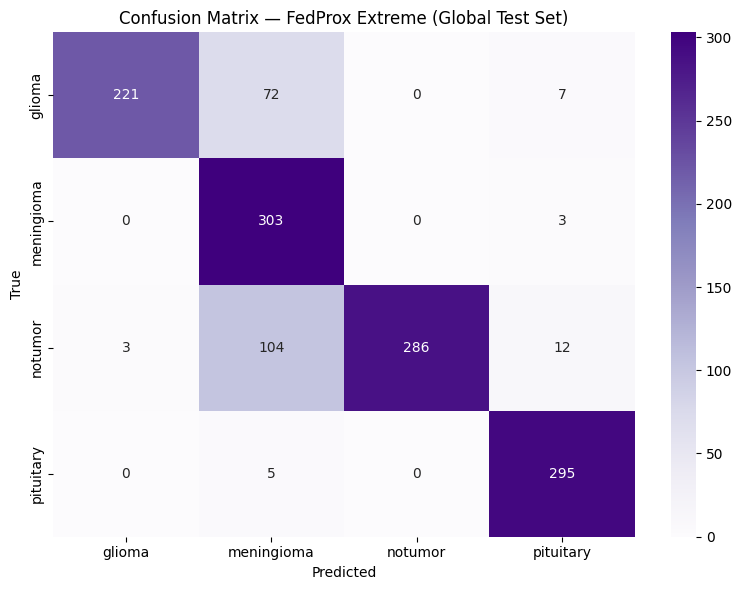

Saved → fedprox_extreme_confusion_matrix.npy


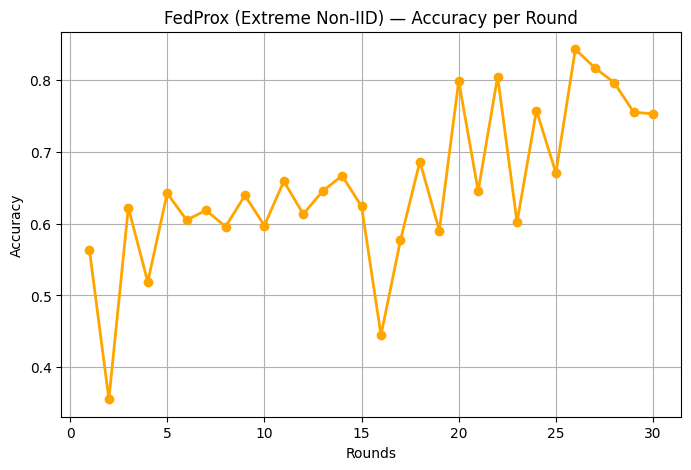

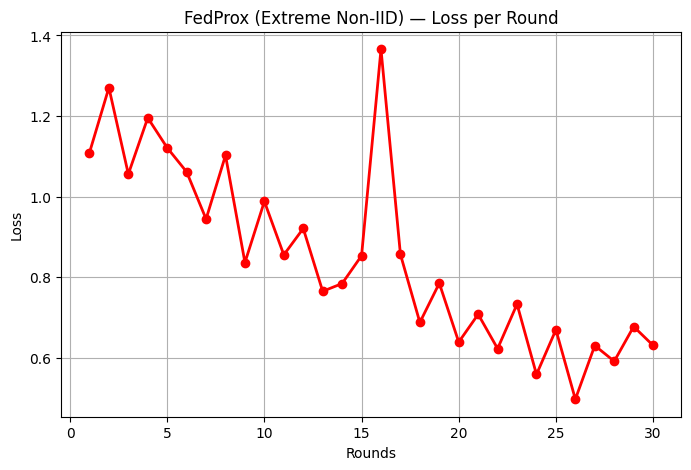


📊 Evaluation completed successfully.


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import torch.nn as nn
from torchvision import models
import seaborn as sns

# ============================================================
# DEVICE
# ============================================================
DEVICE = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

print("Using device:", DEVICE)

# ============================================================
# MODEL ARCHITECTURE (must match training-time architecture)
# ============================================================
def create_pretrained_resnet18_ext_fedprox_eval(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze same layers as before
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Train deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace FC
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
# LOAD BEST MODEL (Extreme FedProx)
# ============================================================
NUM_CLASSES = len(train_dataset.classes)

best_model_fp_ext = create_pretrained_resnet18_ext_fedprox_eval(NUM_CLASSES)
best_model_fp_ext.load_state_dict(torch.load("best_fedprox_extreme_pretrained_newmu.pth"))
best_model_fp_ext.to(DEVICE)
best_model_fp_ext.eval()

print("✅ Best FedProx Extreme model loaded.")


# ============================================================
# EVALUATION FUNCTION
# ============================================================
crit = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate_full(model, loader):
    model.eval()
    total_loss = 0
    preds_all = []
    labels_all = []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = crit(logits, y)

        total_loss += loss.item() * x.size(0)
        preds_all.append(logits.argmax(1).cpu())
        labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    acc = (preds_all == labels_all).mean()
    prec = precision_score(labels_all, preds_all, average="macro", zero_division=0)
    rec = recall_score(labels_all, preds_all, average="macro", zero_division=0)
    f1 = f1_score(labels_all, preds_all, average="macro", zero_division=0)
    loss = total_loss / len(labels_all)

    return {
        "loss": loss,
        "acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "preds": preds_all,
        "labels": labels_all
    }


# ============================================================
# RUN GLOBAL TEST EVALUATION
# ============================================================
results_fp_ext = evaluate_full(best_model_fp_ext, holdout_loader_ext_fp)

print("\n====== FedProx Extreme — FINAL GLOBAL TEST RESULTS ======")
for k, v in results_fp_ext.items():
    if k not in ("preds", "labels"):
        print(f"{k}: {v:.4f}")


# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(results_fp_ext["labels"], results_fp_ext["preds"])
class_names = train_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — FedProx Extreme (Global Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

np.save("fedprox_extreme_confusion_matrix.npy", cm)
print("Saved → fedprox_extreme_confusion_matrix.npy")


# ============================================================
# LOAD TRAINING METRICS HISTORY
# ============================================================
hist_fp = np.load("metrics_history_fedprox_extreme_pretrained_newmu.npy",
                  allow_pickle=True).item()

rounds_fp = hist_fp["round"]
acc_fp = [m["acc"] for m in hist_fp["holdout"]]
loss_fp = [m["loss"] for m in hist_fp["holdout"]]


# ============================================================
# PLOT ACCURACY CURVE
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(rounds_fp, acc_fp, marker="o", linewidth=2, color="orange")
plt.title("FedProx (Extreme Non-IID) — Accuracy per Round")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


# ============================================================
# PLOT LOSS CURVE
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(rounds_fp, loss_fp, marker="o", linewidth=2, color="red")
plt.title("FedProx (Extreme Non-IID) — Loss per Round")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("\n📊 Evaluation completed successfully.")


Using: mps
Models loaded successfully.

===== FINAL GLOBAL TEST RESULTS (EXTREME) =====

FedAvg Extreme:
  loss: 0.4248
  acc: 0.9252
  precision: 0.9251
  recall: 0.9315
  f1: 0.9262

FedProx Extreme:
  loss: 0.4968
  acc: 0.8429
  precision: 0.8858
  recall: 0.8541
  f1: 0.8487


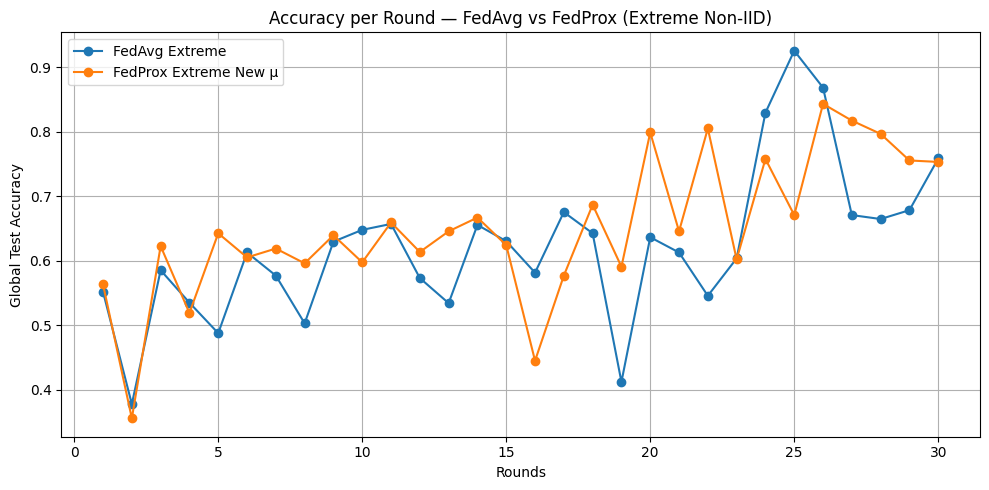

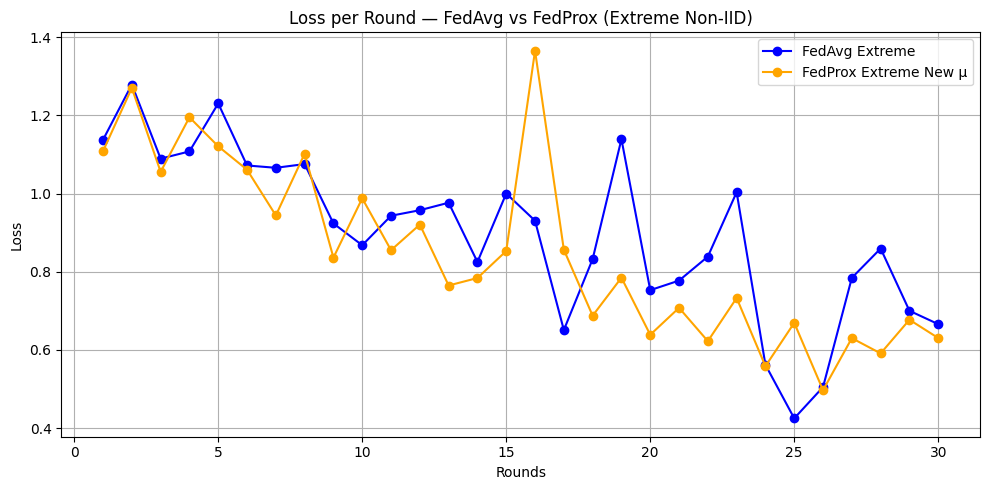

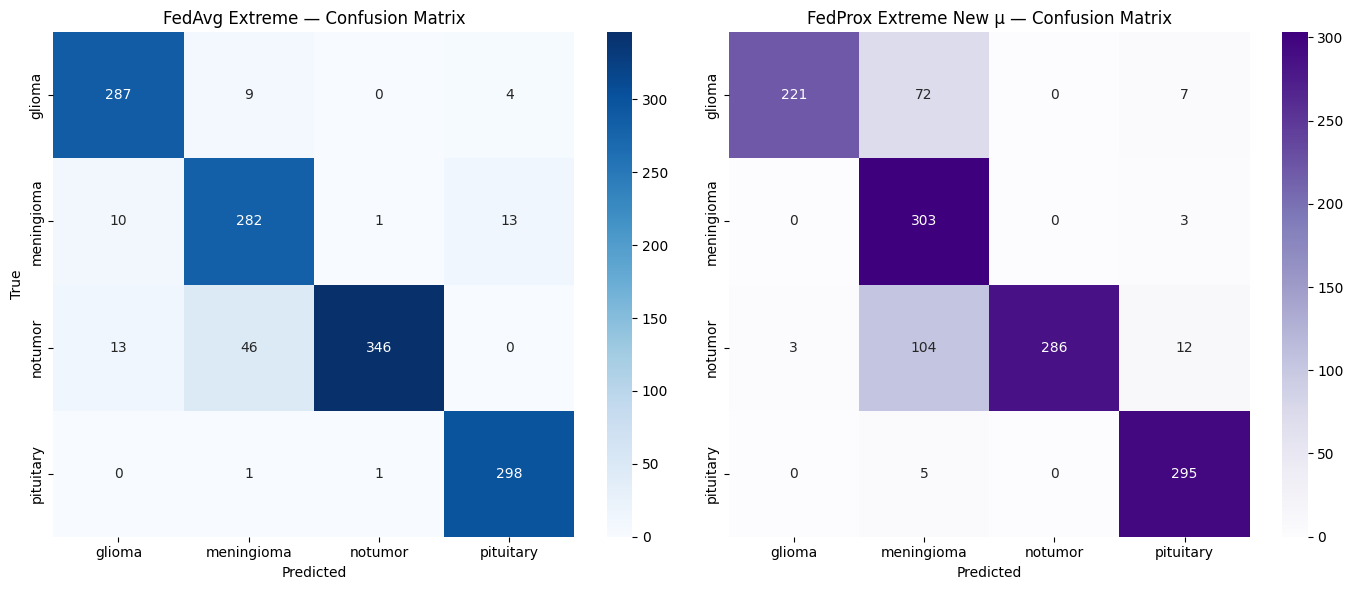

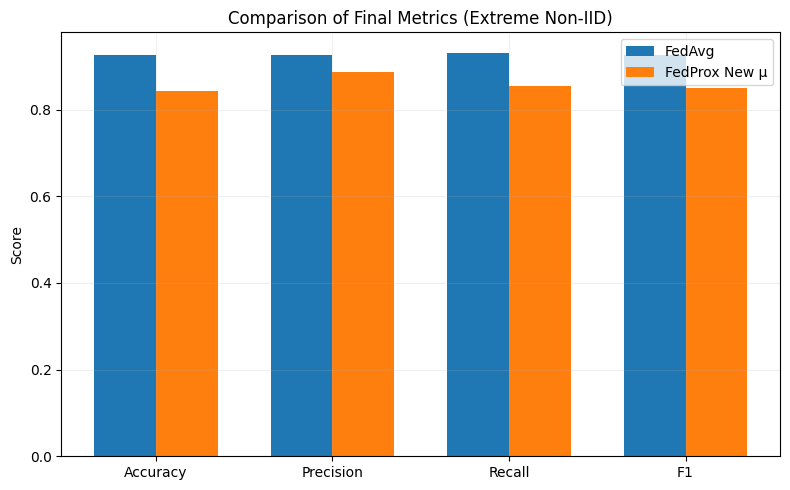

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import torch.nn as nn
from torchvision import models


DEVICE = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print("Using:", DEVICE)

# ============================================================
# MATCHING MODEL ARCHITECTURE
# ============================================================
def create_resnet18_ext(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze same layers as training
    for p in model.conv1.parameters(): p.requires_grad = False
    for p in model.bn1.parameters(): p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


NUM_CLASSES = len(train_dataset.classes)


# ============================================================
# LOAD BEST MODELS
# ============================================================
fedavg_model = create_resnet18_ext(NUM_CLASSES).to(DEVICE)
fedavg_model.load_state_dict(torch.load("best_fedavg_extreme_pretrained.pth"))
fedavg_model.eval()

fedprox_model = create_resnet18_ext(NUM_CLASSES).to(DEVICE)
fedprox_model.load_state_dict(torch.load("best_fedprox_extreme_pretrained_newmu.pth"))
fedprox_model.eval()

print("Models loaded successfully.")


# ============================================================
# GENERIC EVAL FUNCTION
# ============================================================
crit = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate_full(model, loader):
    total_loss = 0
    preds_all = []
    labels_all = []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = crit(logits, y)

        total_loss += loss.item() * x.size(0)
        preds_all.append(logits.argmax(1).cpu())
        labels_all.append(y.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()

    return {
        "loss": total_loss / len(labels_all),
        "acc": (preds_all == labels_all).mean(),
        "precision": precision_score(labels_all, preds_all, average="macro", zero_division=0),
        "recall": recall_score(labels_all, preds_all, average="macro", zero_division=0),
        "f1": f1_score(labels_all, preds_all, average="macro", zero_division=0),
        "preds": preds_all,
        "labels": labels_all
    }


# ============================================================
# EVALUATE BOTH ON GLOBAL TEST SET
# ============================================================
fa_res = evaluate_full(fedavg_model, holdout_loader_ext)
fp_res = evaluate_full(fedprox_model, holdout_loader_ext_fp)

print("\n===== FINAL GLOBAL TEST RESULTS (EXTREME) =====")
print("\nFedAvg Extreme:")
for k, v in fa_res.items():
    if k not in ("preds", "labels"):
        print(f"  {k}: {v:.4f}")

print("\nFedProx Extreme:")
for k, v in fp_res.items():
    if k not in ("preds", "labels"):
        print(f"  {k}: {v:.4f}")


# ============================================================
# PLOT ACCURACY CURVES
# ============================================================
fa_hist = np.load("metrics_history_fedavg_extreme_pretrained.npy", allow_pickle=True).item()
fp_hist = np.load("metrics_history_fedprox_extreme_pretrained_newmu.npy", allow_pickle=True).item()

rounds_fa = fa_hist["round"]
rounds_fp = fp_hist["round"]

acc_fa = [m["acc"] for m in fa_hist["holdout"]]
acc_fp = [m["acc"] for m in fp_hist["holdout"]]

plt.figure(figsize=(10,5))
plt.plot(rounds_fa, acc_fa, marker="o", label="FedAvg Extreme")
plt.plot(rounds_fp, acc_fp, marker="o", label="FedProx Extreme New μ")
plt.xlabel("Rounds")
plt.ylabel("Global Test Accuracy")
plt.title("Accuracy per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# PLOT LOSS CURVES
# ============================================================
loss_fa = [m["loss"] for m in fa_hist["holdout"]]
loss_fp = [m["loss"] for m in fp_hist["holdout"]]

plt.figure(figsize=(10,5))
plt.plot(rounds_fa, loss_fa, marker="o", label="FedAvg Extreme", color="blue")
plt.plot(rounds_fp, loss_fp, marker="o", label="FedProx Extreme New μ", color="orange")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Loss per Round — FedAvg vs FedProx (Extreme Non-IID)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# SIDE-BY-SIDE CONFUSION MATRICES
# ============================================================
cm_fa = confusion_matrix(fa_res["labels"], fa_res["preds"])
cm_fp = confusion_matrix(fp_res["labels"], fp_res["preds"])
class_names = train_dataset.classes

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(cm_fa, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=ax[0])
ax[0].set_title("FedAvg Extreme — Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(cm_fp, annot=True, fmt='d', cmap="Purples",
            xticklabels=class_names, yticklabels=class_names, ax=ax[1])
ax[1].set_title("FedProx Extreme New μ — Confusion Matrix")
ax[1].set_xlabel("Predicted")

plt.tight_layout()
plt.show()


# ============================================================
# METRIC BAR CHART (ACC, PREC, REC, F1)
# ============================================================
labels = ["Accuracy", "Precision", "Recall", "F1"]
fa_vals = [fa_res["acc"], fa_res["precision"], fa_res["recall"], fa_res["f1"]]
fp_vals = [fp_res["acc"], fp_res["precision"], fp_res["recall"], fp_res["f1"]]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, fa_vals, w, label="FedAvg")
plt.bar(x + w/2, fp_vals, w, label="FedProx New μ")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Comparison of Final Metrics (Extreme Non-IID)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


extra code down

In [23]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# ============================================================
#                    DEVICE SELECTION
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#        CONFIG — FedProx + Pretrained ResNet18 (EXTREME)
# ============================================================
SEED_EXT_FP        = 77
NUM_ROUNDS_EXT_FP  = 30        # federated rounds
LOCAL_EPOCHS_EXT_FP = 5        # local epochs per round
LR_EXT_FP          = 3e-4      # learning rate
FEDPROX_MU_EXT     = 0.1     # FedProx μ for extreme non-IID
BATCH_SIZE_EXT_FP  = 32

# Extreme non-IID partitions already built as in your Dirichlet code:
# client_data = [(client0_train, client0_test), ..., (clientN_train, clientN_test)]
NUM_CLIENTS_EXT_FP = len(client_data)
NUM_CLASSES_EXT_FP = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED_EXT_FP)
np.random.seed(SEED_EXT_FP)
torch.manual_seed(SEED_EXT_FP)
torch.cuda.manual_seed_all(SEED_EXT_FP)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_ext_fp = nn.CrossEntropyLoss()

# ============================================================
#      PRETRAINED RESNET18 (SAME FREEZING AS OTHER EXPERIMENTS)
# ============================================================
def create_pretrained_resnet18_ext_fedprox(num_classes: int) -> nn.Module:
    """
    ResNet18 with ImageNet weights for Extreme Non-IID FedProx.
    Freeze: conv1, bn1, layer1, layer2
    Train : layer3, layer4, fc
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for p in model.conv1.parameters():  p.requires_grad = False
    for p in model.bn1.parameters():    p.requires_grad = False
    for p in model.layer1.parameters(): p.requires_grad = False
    for p in model.layer2.parameters(): p.requires_grad = False

    # Fine-tune deeper layers
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True

    # Replace classifier head
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#                   CLIENT LOADERS (EXTREME)
# ============================================================
client_train_loaders_ext_fp = []
client_test_loaders_ext_fp  = []

for train_subset, test_subset in client_data:
    client_train_loaders_ext_fp.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=True, num_workers=0)
    )
    client_test_loaders_ext_fp.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_EXT_FP, shuffle=False, num_workers=0)
    )

# -------- GLOBAL HOLDOUT LOADER (TRUE TEST SET) --------
holdout_loader_ext_fp = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EXT_FP,
    shuffle=False,
    num_workers=0
)
print(f"Extreme FedProx — Global holdout size: {len(test_dataset)}")

# ============================================================
#               GENERIC EVAL FUNCTION (REUSED)
# ============================================================
@torch.no_grad()
def evaluate_ext_fp(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce_ext_fp(logits, y)

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#               FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch_ext_fp(model, loader, device, optimizer, global_params, mu):
    """
    One local epoch of FedProx for extreme non-IID clients.
    global_params: dict[name -> tensor] from the global model.
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce_ext_fp(logits, y)

        # Proximal penalty (only for trainable parameters)
        prox_term = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad:
                prox_term = prox_term + ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss    += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total         += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc":  total_correct / max(total, 1)
    }

# ============================================================
#             INITIALIZE GLOBAL FedProx MODEL (EXTREME)
# ============================================================
global_model_ext_fp = create_pretrained_resnet18_ext_fedprox(NUM_CLASSES_EXT_FP).to(DEVICE)

best_global_acc_ext_fp   = -1.0
best_global_state_ext_fp = None

metrics_history_fedprox_extreme_pretrained_newmu1 = {
    "round":   [],
    "holdout": [],                          # list of {"loss":..., "acc":...}
    "clients": {k: [] for k in range(NUM_CLIENTS_EXT_FP)}  # per-client metrics
}

# ============================================================
#                     FEDPROX MAIN LOOP (EXTREME)
# ============================================================
for rnd in range(NUM_ROUNDS_EXT_FP):
    print(f"\n🔁 [EXTREME] FedProx Pretrained Round {rnd+1}/{NUM_ROUNDS_EXT_FP}")
    local_states = []

    # Cache global parameters for proximal term
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_ext_fp.named_parameters()
    }

    # ---------- LOCAL TRAINING ----------
    for k in range(NUM_CLIENTS_EXT_FP):
        local_model = copy.deepcopy(global_model_ext_fp).to(DEVICE)

        optimizer = optim.Adam(
            (p for p in local_model.parameters() if p.requires_grad),
            lr=LR_EXT_FP
        )

        for _ in range(LOCAL_EPOCHS_EXT_FP):
            train_metrics_k = train_fedprox_epoch_ext_fp(
                local_model,
                client_train_loaders_ext_fp[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU_EXT
            )

        # Store local state dict (on CPU)
        local_states.append({
            key: val.cpu() for key, val in local_model.state_dict().items()
        })

        # Evaluate on each client's local TEST split
        client_metric = evaluate_ext_fp(local_model, client_test_loaders_ext_fp[k], DEVICE)
        metrics_history_fedprox_extreme_pretrained["clients"][k].append(client_metric)
        print(f"  Client {k} | Local Test Acc: {client_metric['acc']:.4f}")

    # ---------- FEDERATED AVERAGING ----------
    new_state = {}
    for key in global_model_ext_fp.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_ext_fp.load_state_dict(new_state)

    # ---------- GLOBAL EVALUATION ON TRUE TEST SET ----------
    holdout_metric = evaluate_ext_fp(global_model_ext_fp, holdout_loader_ext_fp, DEVICE)
    metrics_history_fedprox_extreme_pretrained_newmu1["round"].append(rnd + 1)
    metrics_history_fedprox_extreme_pretrained_newmu1["holdout"].append(holdout_metric)

    print(f"🌍 [EXTREME] FedProx Global | Loss: {holdout_metric['loss']:.4f} | "
          f"Acc: {holdout_metric['acc']:.4f}")

    # ---------- SAVE BEST GLOBAL MODEL ----------
    if holdout_metric["acc"] > best_global_acc_ext_fp:
        best_global_acc_ext_fp   = holdout_metric["acc"]
        best_global_state_ext_fp = copy.deepcopy(global_model_ext_fp.state_dict())
        print(f"💾 New BEST [EXTREME] FedProx Model Saved! Acc = {best_global_acc_ext_fp:.4f}")

# ============================================================
#                 SAVE BEST MODEL + METRICS (EXTREME)
# ============================================================
if best_global_state_ext_fp is not None:
    torch.save(best_global_state_ext_fp, "best_fedprox_extreme_pretrained_newmu1.pth")
    print(f"\n✅ Best Extreme FedProx-pretrained model saved to "
          f"best_fedprox_extreme_pretrained_newmu1.pth (Acc = {best_global_acc_ext_fp:.4f})")
else:
    print("\n⚠️ No improvement — no Extreme FedProx-pretrained model saved.")

np.save(
    "metrics_history_fedprox_extreme_pretrained_newmu1.npy",
    metrics_history_fedprox_extreme_pretrained_newmu1,
    allow_pickle=True
)
print("📊 Metrics history saved to metrics_history_fedprox_extreme_pretrained_newmu1.npy")


🚀 Using Apple Silicon GPU (MPS)
Extreme FedProx — Global holdout size: 1311

🔁 [EXTREME] FedProx Pretrained Round 1/30
  Client 0 | Local Test Acc: 0.9692
  Client 1 | Local Test Acc: 0.9701
  Client 2 | Local Test Acc: 0.9487
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 1.0045 | Acc: 0.5736
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.5736

🔁 [EXTREME] FedProx Pretrained Round 2/30
  Client 0 | Local Test Acc: 0.9758
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9316
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 0.9584 | Acc: 0.6156
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.6156

🔁 [EXTREME] FedProx Pretrained Round 3/30
  Client 0 | Local Test Acc: 0.9824
  Client 1 | Local Test Acc: 0.9627
  Client 2 | Local Test Acc: 0.9744
  Client 3 | Local Test Acc: 1.0000
🌍 [EXTREME] FedProx Global | Loss: 0.8341 | Acc: 0.6423
💾 New BEST [EXTREME] FedProx Model Saved! Acc = 0.6423

🔁 [EXTREME] FedProx Pretraine